### Closed-loop control of a deformable mirror (DM)
#### using SVD pseudo-inversion of DM influence matrix
#### and low-pass filtering of the eigenvalues for improved convergence stability

Hardware used: 
* Thorlabs WFS-150 Shack-Hartmann sensor
* Mirao52e deformable mirror

This code uses Thorlabs 64-bit WFS driver installed via [Thorlabs WFS Software](https://www.thorlabs.com/software_pages/ViewSoftwarePage.cfm?Code=WFS).

Tested using Anaconda 64-bit Python 2.7 distribution, Windows 10.

Author: [Nikita Vladimirov](mailto:nikita.vladimirov@mdc-berlin.de)

In [1]:
import ctypes as ct
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sys
sys.path.append('./lib')
from Mirao52_utils import *

In [2]:
#define home dir of the code:
homeDir = 'C:/Users/Nikita/Documents/GitHub/AO-toolkit/'

#load the WFS DLL:
WFS = ct.windll.WFS_64

#Load the Mirao52e DLL:
DM = ct.windll.LoadLibrary('./lib/x64/mirao52e.dll')
byref = ct.byref

In [3]:
#Set the data types compatible with C DLL
count = ct.c_int32() 
deviceID  = ct.c_int32()  
instrumentListIndex  = ct.c_int32() 
inUse = ct.c_int32() 
instrumentName = ct.create_string_buffer("", 256)
instrumentSN = ct.create_string_buffer("", 256)
resourceName = ct.create_string_buffer("", 256)
IDQuery = ct.c_bool()
resetDevice = ct.c_bool()
instrumentHandle = ct.c_ulong()
pupilCenterXMm = ct.c_double()
pupilCenterYMm = ct.c_double()
pupilDiameterXMm = ct.c_double()
pupilDiameterYMm = ct.c_double()
exposureTimeAct = ct.c_double()
masterGainAct = ct.c_double()
dynamicNoiseCut = ct.c_int32() 
calculateDiameters = ct.c_int32() 
cancelWavefrontTilt = ct.c_int32() 
errorMessage = ct.create_string_buffer("", 512)
errorCode = ct.c_int32()
pixelFormat = ct.c_int32()
pixelFormat.value = 0 #currently 8 bit only
camResolIndex = ct.c_int32()
spotsX = ct.c_int32()
spotsY = ct.c_int32()
wavefrontType = ct.c_int32() 
limitToPupil = ct.c_int32() 

In [4]:
#Set the WFS parameter values
MAX_SPOTS_X = 50
MAX_SPOTS_Y = 40
arrayWavefront = np.zeros((MAX_SPOTS_Y,MAX_SPOTS_X),dtype = np.float32)
instrumentListIndex.value = 0 #0,1,2,, if multiple instruments connected

#Configure WFS camera
camResolIndex.value = 1
# camResolIndex values:
# For WFS instruments: 
# Index  Resolution 
# 0    1280x1024          
# 1    1024x1024          
# 2     768x768            
# 3     512x512            
# 4     320x320 
# For WFS10 instruments: 
# Index  Resolution 
# 0     640x480          
# 1     480x480          
# 2     360x360            
# 3     260x260            
# 4     180x180 
# For WFS20 instruments: 
# Index  Resolution 
# 0    1440x1080             
# 1    1080x1080             
# 2     768x768               
# 3     512x512               
# 4     360x360               
# 5     720x540, bin2 
# 6     540x540, bin2 
# 7     384x384, bin2 
# 8     256x256, bin2 
# 9     180x180, bin2

#Set pupil
pupilCenterXMm.value = 0 #mm
pupilCenterYMm.value = 0 #mm
pupilDiameterXMm.value = 4.5 #mm
pupilDiameterYMm.value = 4.5 #mm

#Set spot calculation params
dynamicNoiseCut.value = 1
calculateDiameters.value = 0
cancelWavefrontTilt.value = 1

wavefrontType.value = 0
# This parameter defines the type of wavefront to calculate. 
# Valid settings for wavefrontType: 
# 0   Measured Wavefront 
# 1   Reconstructed Wavefront based on Zernike coefficients 
# 2   Difference between measured and reconstructed Wavefront 
# Note: Function WFS_CalcReconstrDeviations needs to be called prior to this function in case of Wavefront type 1 and 2.


limitToPupil.value = 1
# This parameter defines if the Wavefront should be calculated based on all detected spots or only within the defined pupil. 
# Valid settings: 
# 0   Calculate Wavefront for all spots 
# 1   Limit Wavefront to pupil interior

In [5]:
#Check how many WFS devices are connected
WFS.WFS_GetInstrumentListLen(None,byref(count))
print('WFS sensors connected: ' + str(count.value))

#Select a device and get its info
devStatus = WFS.WFS_GetInstrumentListInfo(None,instrumentListIndex, byref(deviceID), byref(inUse),
                             instrumentName, instrumentSN, resourceName)
if(devStatus != 0):
    errorCode.value = devStatus
    WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_GetInstrumentListInfo():' + str(errorMessage.value))
else:
    print('WFS deviceID: ' + str(deviceID.value))
    print('in use? ' + str(inUse.value))
    print('instrumentName: ' + str(instrumentName.value))
    print('instrumentSN: ' + str(instrumentSN.value))
    print('resourceName: ' + str(resourceName.value))

if not inUse.value:
    devStatus = WFS.WFS_init(resourceName, IDQuery, resetDevice, byref(instrumentHandle))
    if(devStatus != 0):
        errorCode.value = devStatus
        WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
        print('error in WFS_init():' + str(errorMessage.value))
    else:
        print('WFS has been initialized. Instrument handle: ' +str(instrumentHandle.value))
else:
    print('WFS already in use')

WFS sensors connected: 1
WFS deviceID: 1
in use? 0
instrumentName: WFS150-7AR
instrumentSN: M00313725
resourceName: USB::0x1313::0x0000::1
WFS has been initialized. Instrument handle: 169295952


In [6]:
#Configure WFS camera
devStatus = WFS.WFS_ConfigureCam(instrumentHandle, 
                                 pixelFormat, camResolIndex, byref(spotsX), byref(spotsY))
if(devStatus != 0):
    errorCode.value = devStatus
    WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_ConfigureCam():' + str(errorMessage.value))
else:
    print('WFS camera configured')
    print('SpotsX: ' + str(spotsX.value))
    print('SpotsY: ' + str(spotsY.value))

#Set pupil
devStatus = WFS.WFS_SetPupil(instrumentHandle,
                             pupilCenterXMm, pupilCenterYMm, pupilDiameterXMm, pupilDiameterYMm)
if(devStatus != 0):
    errorCode.value = devStatus
    WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_SetPupil():' + str(errorMessage.value))
else:
    print('WFS pupil set')
    
nSensorPoints = spotsX.value * spotsY.value

WFS camera configured
SpotsX: 29
SpotsY: 29
WFS pupil set


In [7]:
def WFS_getAveragedWavefront(N = 10, lamb = 0.633):
    '''
    Measure the average wavefront from WF sensor and return it as 2D array
    Parameters:
        N - number of measurements (default 10)
        lamb - wavelengh of the light to convert (default 0.633 micron, HeNe laser)
    Returns:
        meanWavefront - wavefront 2D-array, units: lambdas
        PV - peak to value, units: lambdas
        RMS - root-mean-square, units: lambdas
    '''
    meanWavefront = np.zeros((spotsY.value,spotsX.value))
    for t in range(N):
        #Take a spotfield image, with auto-exposure
        devStatus = WFS.WFS_TakeSpotfieldImageAutoExpos(instrumentHandle,
                                                        byref(exposureTimeAct), byref(masterGainAct))
        if(devStatus != 0):
            errorCode.value = devStatus
            WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
            print('error in WFS_TakeSpotfieldImageAutoExpos():' + str(errorMessage.value))

        #calculate spot centroids
        devStatus = WFS.WFS_CalcSpotsCentrDiaIntens(instrumentHandle, dynamicNoiseCut, calculateDiameters)
        if(devStatus != 0):
            errorCode.value = devStatus
            WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
            print('error in WFS_CalcSpotsCentrDiaIntens():' + str(errorMessage.value))

        #calculate spot to reference deviations
        devStatus = WFS.WFS_CalcSpotToReferenceDeviations(instrumentHandle, cancelWavefrontTilt)
        if(devStatus != 0):
            errorCode.value = devStatus
            WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
            print('error in WFS_CalcSpotToReferenceDeviations():' + str(errorMessage.value))

        #calculate the wavefront
        devStatus = WFS.WFS_CalcWavefront(instrumentHandle, 
                                          wavefrontType, limitToPupil, arrayWavefront.ctypes.data)
        if(devStatus != 0):
            errorCode.value = devStatus
            WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
            print('error in WFS_CalcWavefront():' + str(errorMessage.value))   
        
        #save the data as numpy array
        meanWavefront[:,:] += arrayWavefront[:spotsY.value,:spotsX.value].copy()
        
    #Calculate stats, units: lambda
    meanWavefront = meanWavefront/N/lamb
    meanWavefront = meanWavefront - np.nanmean(meanWavefront) #normalize by the mean
    PV = np.nanmax(meanWavefront) - np.nanmin(meanWavefront)
    RMS = np.sqrt(np.nanmean(meanWavefront**2,axis=(0,1)))

    return (meanWavefront, PV, RMS)

In [8]:
#open the DM session
dm_nActuators = 52
dm_trigger = ct.c_int32() 
dm_trigger.value = 0
dm_status  = ct.c_int32() 

assert DM.mro_open(byref(dm_status)), errors[dm_status.value]

In [9]:
def safe_voltage(cmd):
    "returns 1 if command data in the safe zone, between -1 and 1 Volt for individual actuators, and < 25 Volt sum of absolute values, \
     returns 0 if unsafe"
    if cmd.min() >= -1.0 and cmd.max() <= 1.0 and np.sum(np.abs(cmd)) < 25.0:
        return 1
    else:
        return 0

In [58]:
%%time
#Measure the poke matrix of DM
flat_path = homeDir +  'python/flat/FLAT_MIRAO_0274-01.mro'
dm_command_flat = read_Mirao_commandFile(flat_path,DM)
dm_command = np.zeros(dm_nActuators, dtype=np.float64)

Varray = np.array([-0.25, 0.25]) #Volts, this is applied to every actuator sequentially
PokeMatrix = np.zeros((len(Varray),nSensorPoints, dm_nActuators))

for iVolts in range(len(Varray)):
    for iActuator in range(dm_nActuators):
        dm_command[:] = 0
        dm_command[iActuator] = Varray[iVolts]
        #cmd = dm_command + dm_command_flat
        cmd = dm_command
        #apply poke to DM actuator
        if safe_voltage(cmd):
            assert DM.mro_applySmoothCommand(cmd.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
        else:
            print 'Error: voltage is outside of safe range'
        #measure the wavefront
        WF,_,_ = WFS_getAveragedWavefront(N=40)
        WF = WF - np.nanmean(WF) #WF is measured to arbitrary constant, so normalize by the mean
        WF = WF.reshape(nSensorPoints) # 2D -> 1D
        PokeMatrix[iVolts,:,iActuator] = np.nan_to_num(WF)/Varray[iVolts] #rescale to unit voltage vector and remember

#reset DM to flat shape
assert DM.mro_applySmoothCommand(dm_command_flat.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]

Wall time: 9min 17s


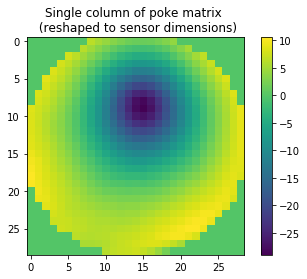

In [11]:
#Check PokeMatrix
iActuator = 29
plt.imshow(PokeMatrix[0,:,iActuator].reshape((29,29)),aspect = 'equal')
plt.title('Single column of poke matrix \n (reshaped to sensor dimensions)')
plt.colorbar()

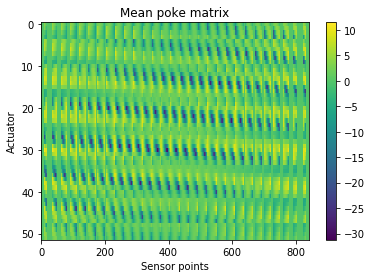

In [59]:
PokeMatrix_ave = PokeMatrix.mean(axis=0)
# Plot mean poke matrices with +V and -V pokes
plt.imshow(PokeMatrix_ave.T,aspect = 'auto')
plt.xlabel('Sensor points')
plt.ylabel('Actuator')
plt.title('Mean poke matrix')
plt.colorbar()

In [60]:
#do the SVD pseudo-inverse now
U, s, V = np.linalg.svd(PokeMatrix_ave, full_matrices=False)

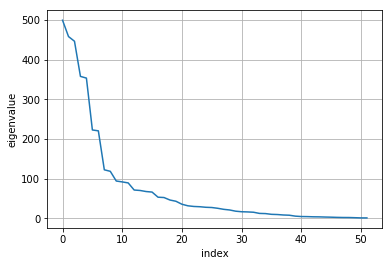

In [61]:
#plot the eigenvalues
plt.plot(s)
plt.grid('on')
plt.xlabel('index')
plt.ylabel('eigenvalue')

In [62]:
print(s)

[ 499.72375046  458.54561108  446.73000545  358.04328918  353.73571899
  222.84631283  220.6814033   122.34187802  118.53195929   94.0537679
   91.81189115   89.24280361   71.3475994    70.16416594   67.51262152
   66.15160872   53.22002891   52.37538857   46.05863174   42.97170543
   35.47354845   31.52326429   29.83811683   29.16830244   27.78159786
   27.18848844   25.2357226    22.6065109    20.98400465   17.93823979
   16.53215031   16.05353964   15.26156623   12.31376863   11.87328857
   10.00626778    9.48244491    8.32806129    7.73629855    5.43024317
    4.42544186    4.22711342    3.75643432    3.59110375    3.12895579
    2.79423435    2.29676056    2.00312297    1.92538859    1.489854
    0.96674327    0.94115597]


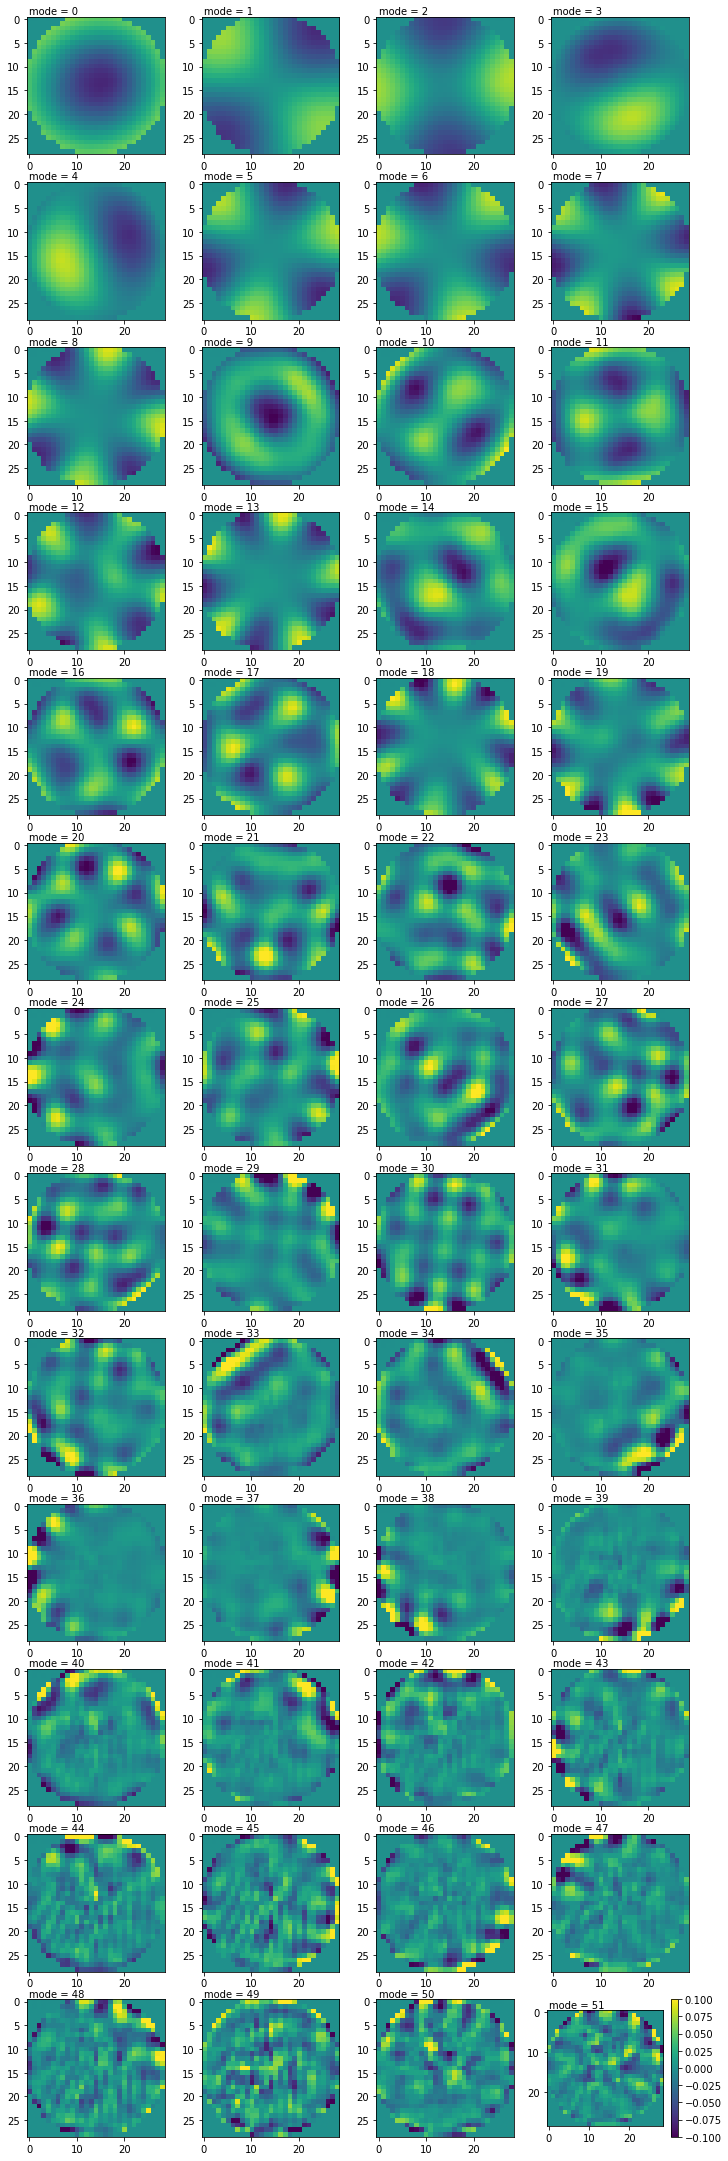

In [63]:
#show the DM orthogonal modes
nPrimaryModes = 52
dm_modes = np.zeros((nPrimaryModes,spotsX.value,spotsY.value))
for ind in range(nPrimaryModes):
    dm_modes[ind,:,:] = U[:,ind].reshape((spotsX.value,spotsY.value))

#plot first n x m modes
n = 4
m = 13
zmin = -0.1
zmax = 0.1
fig, ax = plt.subplots(m,n, figsize = (3*n,3*m))
for i in range(n):
    for j in range(m):
        im = ax[j,i].imshow(dm_modes[i+j*n],vmin = zmin, vmax = zmax, aspect='equal')
        ax[j,i].text(0,-1, 'mode = ' + str(i+j*n),fontsize=10)
fig.colorbar(im, ax = ax[j,i])

In [100]:
#Inverse PokeMatrix:
# low-pass the inverse
s_inv = 1.0/s
s_thresh = s[0]/40
s_inv[s < s_thresh] = 0
print('Cut-off modes:' + str(np.where(s_inv == 0)[0]))
S_inv = np.diag(s_inv)
PokeMatrix_inv = np.dot(V.T,np.dot(S_inv, U.T))

Cut-off modes:[33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]


In [101]:
#Set arbitrary DM target profile for test:
DM_diam = 15.0 #mm
x = np.linspace(-DM_diam/2,DM_diam/2,spotsX.value)
y = np.linspace(-DM_diam/2,DM_diam/2,spotsY.value)
X, Y = np.meshgrid(x, y)

def test_gauss(x,y,sigma = 2):
     return np.exp(-x**2/(2*sigma**2) - y**2/(2*sigma**2))
    
def test_defocus(x,y,radius = 2000): #units: mm
    z = np.sqrt(radius**2 - x**2 - y**2)
    return z

def test_flat(x,y):
    return np.ones(x.shape)

DM_target_profile = test_flat(X,Y)
#crop the corners to None values
cropMask = np.ones(DM_target_profile.shape)
crop_radius = DM_diam/2
for i in range(len(x)):
    for j in range(len(y)):
        if x[i]**2 + y[j]**2 >= crop_radius**2: 
            cropMask[i,j] = None
            
DM_target_profile = DM_target_profile * cropMask
#DM_target_profile = DM_target_profile - np.nanmin(DM_target_profile)

In [102]:
#Find the command for target profile, by using pseudo-inverse
DM_target_command = np.dot(PokeMatrix_inv, np.nan_to_num(DM_target_profile).flatten())

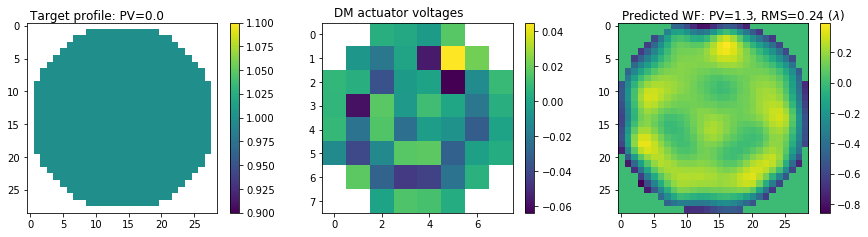

In [103]:
DM_cmd = DM_target_command

fig, ax = plt.subplots(1,3, figsize = (15,3.5))
# target shape
im = ax[0].imshow(DM_target_profile, interpolation='nearest')
PV = np.nanmax(DM_target_profile) - np.nanmin(DM_target_profile)
ax[0].text(0,-1, 'Target profile: PV='"{:2.1f}".format(PV),fontsize=12)
fig.colorbar(im, ax = ax[0])

# DM command map, 2D
im = ax[1].imshow(DM_voltage_to_map(DM_cmd), interpolation='nearest')
ax[1].text(0,-0.75, 'DM actuator voltages',fontsize=12)
fig.colorbar(im, ax = ax[1])

# DM predicted profile: apply the command to the forward matrix A to see the pedicted shape
WF_predicted = np.dot(PokeMatrix_ave,DM_cmd).reshape((spotsX.value,spotsY.value))

im = ax[2].imshow(WF_predicted, interpolation='nearest')
PV = WF_predicted.max() - WF_predicted.min()
RMS = np.sqrt(np.mean(WF_predicted**2))
ax[2].text(0,-1, 'Predicted WF: PV='+"{:2.1f}".format(PV) + 
           ', RMS=' + "{:1.2f}".format(RMS) + ' ($\lambda$)',fontsize=12)
fig.colorbar(im, ax = ax[2])

# Check if command is withing DM allowed limits:
V1abs_max = 1.0 #Volt
Vall_abs_max = 25.0 #Volt

if np.abs(DM_cmd).max() >= V1abs_max:
    print('Voltage too high for individual actuators')
if np.sum(np.abs(DM_cmd)) >= Vall_abs_max:
    print('Total absolute voltage is too high for all actuators')

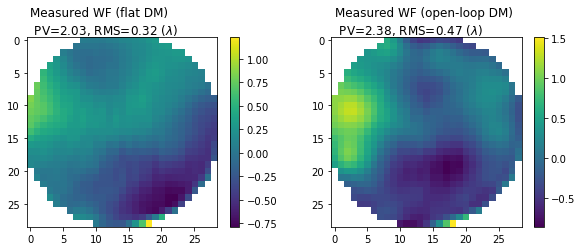

In [105]:
#Open-loop flattening of the WF
fig, ax = plt.subplots(1,2, figsize = (10,3.5))
# measure the 'flat' WF without DM control.
# The WF is not very flat because of imprefect optics and alignment
# reset DM to flat shape
assert DM.mro_applySmoothCommand(dm_command_flat.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
# measure
WF, PV, RMS = WFS_getAveragedWavefront(N=20)
# plot
im = ax[0].imshow(WF, interpolation='nearest')
ax[0].text(0,-1, 'Measured WF (flat DM) \n PV=' + "{:2.2f}".format(PV) +
           ', RMS=' + "{:1.2f}".format(RMS) + ' ($\lambda$)',fontsize=12)
fig.colorbar(im, ax = ax[0])

#Try to make WF flatter by applying open-loop DM control
cmd = DM_target_command
if safe_voltage(cmd):
    assert DM.mro_applySmoothCommand(cmd.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
else:
    print 'Error: voltage is outside of safe range'

#measure 
WF, PV, RMS = WFS_getAveragedWavefront(N=20)

#plot
im = ax[1].imshow(WF, interpolation='nearest')
ax[1].text(0,-1, 'Measured WF (open-loop DM) \n PV=' + "{:2.2f}".format(PV) +
           ', RMS=' + "{:1.2f}".format(RMS) + ' ($\lambda$)',fontsize=12)
fig.colorbar(im, ax = ax[1])

#reset DM back to flat shape
assert DM.mro_applySmoothCommand(dm_command_flat.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]

So the result of **open-loop** control is not very safisfactory - the command for flattening the WF makes WF actually somewhat less flat than before. 

An iterative closed-loop control (with **low-pass filter** by eigenvalues) should be better - see below.

In [111]:
%%time
#Closed-loop control
#set DM to open-loop shape
assert DM.mro_applySmoothCommand(DM_target_command.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
#measure initial WF
WF, _, _ = WFS_getAveragedWavefront(N=20)

DM_target_profile = DM_target_profile - np.nanmean(DM_target_profile) #normalize target profile
DM_CL_command = DM_target_command #set initial command 

n_iterations = 100
gain = -0.2
PV_RMS_timelapse = np.zeros((n_iterations,2))
WF_timelapse = np.zeros((n_iterations,WF.shape[0],WF.shape[1]))

for it in range(n_iterations):
    #Calculate the diff between measured and target WFs:
    WF_diff = WF - DM_target_profile
    WF_diff = WF_diff - np.nanmean(WF_diff) #normalize
    #Find the control command using pseudo-inverse
    DM_command_increment = np.dot(PokeMatrix_inv, np.nan_to_num(WF_diff).flatten())

    #Try to make WF flatter by applying the updated command
    DM_CL_command = DM_CL_command + DM_command_increment*gain
    cmd = DM_CL_command
    if safe_voltage(cmd):
        assert DM.mro_applySmoothCommand(cmd.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
    else:
        print 'Voltage is outside of safe range. Reducing gain.'
        gain /= 2.0

    #measure 
    WF, PV, RMS = WFS_getAveragedWavefront(N=20)
    WF_timelapse[it,:,:] = WF
    PV_RMS_timelapse[it,:] = (PV,RMS)

Wall time: 4min 31s


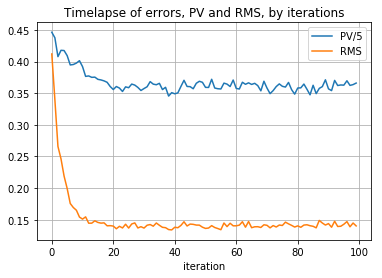

In [115]:
plt.plot(PV_RMS_timelapse[:,0]/5,label='PV/5')
plt.plot(PV_RMS_timelapse[:,1],label='RMS')
plt.legend()
plt.xlabel('iteration')
plt.grid('on')
plt.title('Timelapse of errors, PV and RMS, by iterations')

Note that RMS error stays low once it converged to some small value, so errors do not accumulate as in basic (non-filtered eigenvalues) algorithm.

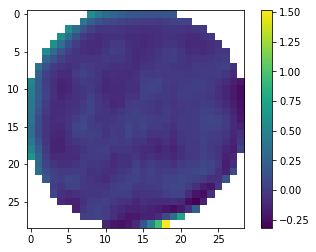

In [116]:
plt.imshow(WF_timelapse[-1,:,:])
plt.colorbar()

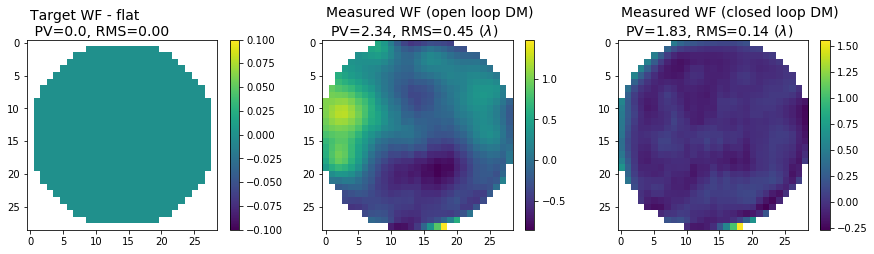

In [117]:
#Plot target, open-loop and closed-loop WFs
fig, ax = plt.subplots(1,3, figsize = (15,3.5))
# target WF
im = ax[0].imshow(DM_target_profile, interpolation='nearest')
PV = np.nanmax(DM_target_profile) - np.nanmin(DM_target_profile)
ax[0].text(0,-1, 'Target WF - flat \n PV=' 
           + "{:2.1f}".format(PV) + ', RMS=' + "{:1.2f}".format(0),fontsize=14)
fig.colorbar(im, ax = ax[0])

# open-loop WF
cmd = DM_target_command
if safe_voltage(cmd):
    assert DM.mro_applySmoothCommand(cmd.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
else:
    print 'Error: voltage is outside of safe range'
#measure 
WF, PV, RMS = WFS_getAveragedWavefront(N=20)
#plot
im = ax[1].imshow(WF, interpolation='nearest')
ax[1].text(0,-1, 'Measured WF (open loop DM) \n PV=' + "{:2.2f}".format(PV) +
           ', RMS=' + "{:1.2f}".format(RMS) + ' ($\lambda$)',fontsize=14)
fig.colorbar(im, ax = ax[1])

# closed-loop WF
cmd = DM_CL_command
if safe_voltage(cmd):
    assert DM.mro_applySmoothCommand(cmd.ctypes.data,dm_trigger,byref(dm_status)), errors[dm_status.value]
else:
    print 'Error: voltage is outside of safe range' 
#measure
WF, PV, RMS = WFS_getAveragedWavefront(N=20)
#plot
im = ax[2].imshow(WF, interpolation='nearest')
ax[2].text(0,-1, 'Measured WF (closed loop DM) \n PV=' + "{:2.2f}".format(PV) +
           ', RMS=' + "{:1.2f}".format(RMS) + ' ($\lambda$)',fontsize=14)
fig.colorbar(im, ax = ax[2])

In [148]:
#close the WFS session
devStatus = WFS.WFS_close(instrumentHandle)
if(devStatus != 0):
    errorCode.value = devStatus
    WFS.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_close():' + str(errorMessage.value))
else:
    print('WFS closed')

WFS closed


In [149]:
#close the DM session
assert DM.mro_close(byref(dm_status)), errors[dm_status.value]